In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

%cd /content/gdrive/My Drive/Kaggle

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Kaggle


In [0]:
!pip install pyspellchecker

     |████████████████████████████████| 1.9MB 2.8MB/s 


In [2]:
import numpy as np 
import pandas as pd
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.util import ngrams
#from spellchecker import SpellChecker
from tqdm import tqdm
from keras.layers import Embedding, LSTM, Dropout, Activation, Dense, BatchNormalization, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
train_path = "/content/gdrive/My Drive/Kaggle/Twitter/train.csv"
test_path = "/content/gdrive/My Drive/Kaggle/Twitter/test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [0]:
for col in train_df.columns:
  print("No. of NaN in {} column = ".format(col), len(train_df[col]) - train_df[col].count())

No. of NaN in id column =  0
No. of NaN in keyword column =  61
No. of NaN in location column =  2533
No. of NaN in text column =  0
No. of NaN in target column =  0


Text(0, 0.5, 'samples')

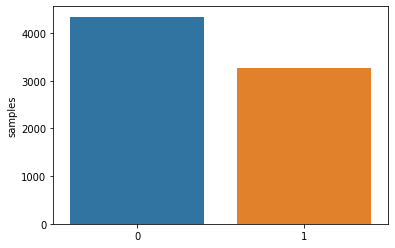

In [0]:
a = train_df['target'].value_counts()
sns.barplot(a.index , a)
plt.gca().set_ylabel('samples')

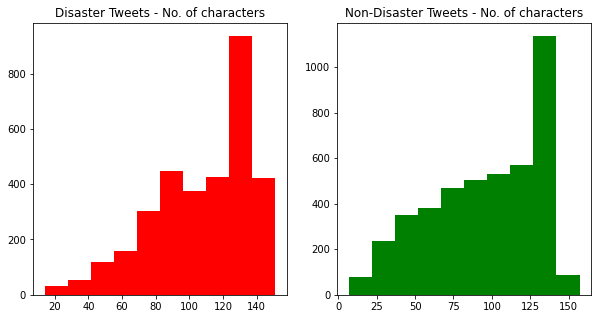

In [0]:
fig , (ax1 , ax2) = plt.subplots(1 ,2 , figsize=(10,5))
tweet_len_pos = train_df[train_df['target'] == 1]['text'].str.len()
ax1.hist(tweet_len_pos , color = 'red')
tweet_len_neg = train_df[train_df['target'] == 0]['text'].str.len()
ax2.hist(tweet_len_neg , color = 'green')
ax1.set_title('Disaster Tweets - No. of characters')
ax2.set_title('Non-Disaster Tweets - No. of characters')
plt.show()

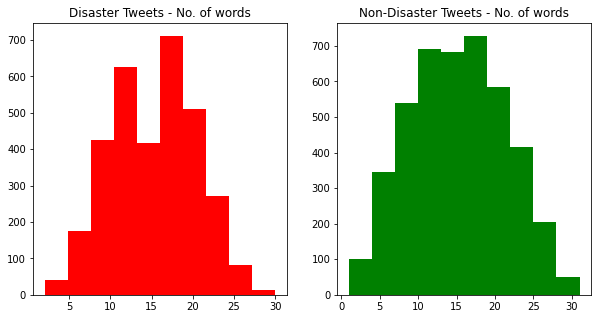

In [0]:
fig , (ax1 , ax2) = plt.subplots(1 ,2 , figsize=(10,5))
tweet_len_pos = train_df[train_df['target'] == 1]['text'].str.split().str.len()
ax1.hist(tweet_len_pos , color = 'red')
tweet_len_neg = train_df[train_df['target'] == 0]['text'].str.split().str.len()
ax2.hist(tweet_len_neg , color = 'green')
ax1.set_title('Disaster Tweets - No. of words')
ax2.set_title('Non-Disaster Tweets - No. of words')
plt.show()

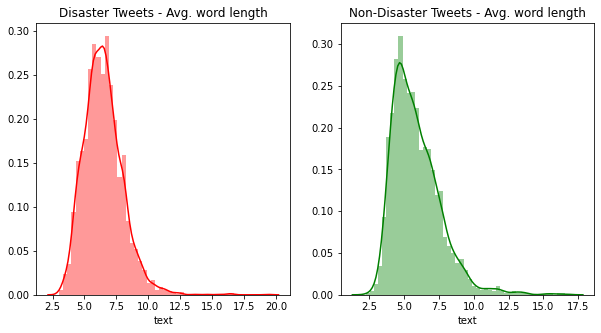

In [0]:
fig , (ax1 , ax2) = plt.subplots(1 ,2 , figsize=(10,5))
data = train_df[train_df['target'] == 1]['text'].str.split().apply(lambda x: [len(i) for i in x])
avg_len = data.map(lambda x : np.mean(x)) 
sns.distplot(avg_len,ax=ax1,color='red')
ax1.set_title('Disaster Tweets - Avg. word length')
data0 = train_df[train_df['target'] == 0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(data0.map(lambda x : np.mean(x)) , ax = ax2 , color = 'green')
ax2.set_title('Non-Disaster Tweets - Avg. word length')
plt.show()

In [0]:
def create_corpus(target):
  corpus = []
  for sentence in train_df[train_df['target'] == target]['text'].str.split():
    for word in sentence:
      corpus.append(word.lower())
  return corpus

<BarContainer object of 10 artists>

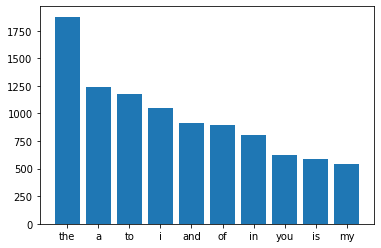

In [0]:
corpus_0 = create_corpus(0)
dict0 = {}
for word in corpus_0:
  dict0[word] =  dict0.get(word,0) + 1
top10 = sorted(dict0.items() , key = lambda x : x[1] , reverse = True)[0:10]
x,y = zip(*top10)
plt.bar(x,y)

<BarContainer object of 10 artists>

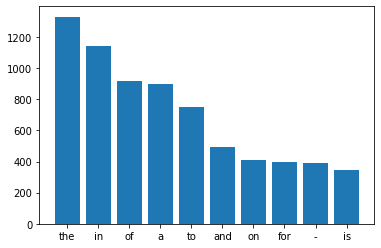

In [0]:
corpus_1 = create_corpus(1)
dict1 = {}
for word in corpus_1:
  dict1[word] = dict1.get(word,0) + 1
top = sorted(dict1.items() , key = lambda x : x[1] , reverse = True)[0:10]
x1 , y1 = zip(*top)
plt.bar(x1,y1)

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
stop = stopwords.words('english')

<BarContainer object of 15 artists>

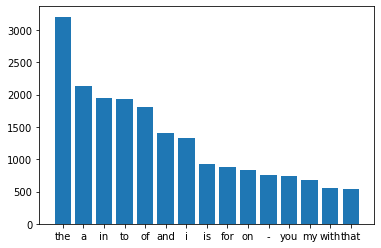

In [0]:
corpus_full = []
for sentence in train_df['text'].str.split():
  for word in sentence:
     corpus_full.append(word.lower())
dict_full = {}
for words in corpus_full:
  dict_full[words] = dict_full.get(words,0) + 1
top15 = sorted(dict_full.items(), key = lambda x : x[1], reverse = True)[0:15]
xf , yf = zip(*top15)
plt.bar(xf , yf)

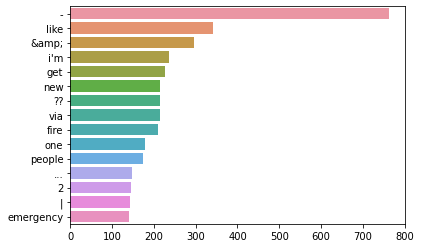

In [0]:
corpus_full = []
for sentence in train_df['text'].str.split():
  for word in sentence:
     corpus_full.append(word.lower())
dict_full = {}
for words in corpus_full:
  if words not in stop:
    dict_full[words] = dict_full.get(words,0) + 1
top15 = sorted(dict_full.items(), key = lambda x : x[1], reverse = True)[0:15]
xff = []
yff = []
for w , c in top15:
  xff.append(w)
  yff.append(c)
sns.barplot(yff,xff)

In [0]:
#N-gram analysis using N = 2
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

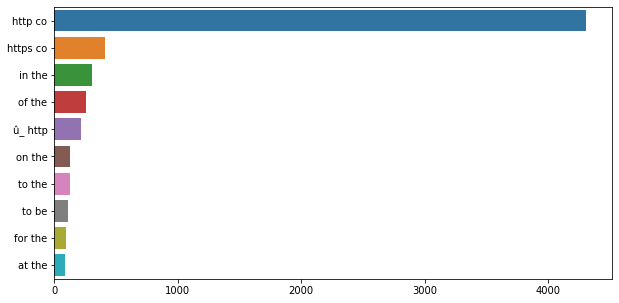

In [0]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(train_df['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

In [0]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [0]:
'''
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
'''

NameError: ignored

In [0]:
def clean_text(texts):
  texts = str(texts).lower()
  texts = re.sub(r"#" , "" , texts)
  texts = re.sub(r"https?://\S+|www\.\S+", "", texts) #remove links
  texts = re.sub('\[.*?\]', '', texts) #remove text in sq brackets
  texts = re.sub(r"'ve\b", " have" , texts)
  texts = re.sub(r"'s\b", " is" , texts)
  texts = re.sub(r"n't\b", " not" , texts)
  texts = re.sub(r"'d\b", " would" , texts)
  texts = re.sub(r"'m\b", " am" , texts)
  texts = re.sub(r"'re\b", " are" , texts)
  texts = re.sub(r"'ll\b", " will" , texts)
  texts = re.sub('[%s]' % re.escape(string.punctuation), '', texts) #remove punctuations !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
  texts = re.sub(r"\W" , " " , texts)
  texts = remove_emoji(texts)
  #texts = correct_spellings(texts)
  
  return texts

In [0]:
train_df['text'] = train_df['text'].apply(lambda x: clean_text(x))

In [9]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
def create_corpus_full(df):
  corpus = []
  for tweet in tqdm(df['text']):
      words=[word for word in nltk.word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))] #word_tokenize -> splits sentence into words
      corpus.append(words)
  return corpus

In [11]:
corpus_train = create_corpus_full(train_df)

100%|██████████| 7613/7613 [00:01<00:00, 5895.26it/s]


In [12]:
corpus_train[0]

['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us']

In [0]:
def get_glove_vectors(file):
    with open(file , 'r') as f:
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            word_to_vec_map[curr_word] = np.array(line[1:] , dtype = np.float64)
        
        
    return word_to_vec_map

glove_path = "/content/gdrive/My Drive/Kaggle/glove.6B.100d.txt"
word_to_vec = get_glove_vectors(glove_path)

In [0]:
MaxLen = 50
n_words = 10_000
tokenizer = Tokenizer(num_words= n_words)
tokenizer.fit_on_texts(corpus_train)
sequences_train = tokenizer.texts_to_sequences(corpus_train)
#sequences_test = tokenizer.texts_to_sequences(testing_sentences)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 16107 unique tokens.


In [0]:
test_sentences = np.asarray(test_df['text'])
sequences_test = tokenizer.texts_to_sequences(test_sentences)
data_test = pad_sequences(sequences_test , maxlen= MaxLen)

In [0]:
data = pad_sequences(sequences_train , maxlen= 50)

In [0]:
def pretrained_embedding_layer(word_to_vec):
    vocab_len = len(word_index) + 1
    emb_dim = word_to_vec['the'].shape[0]
    emb_matrix = np.zeros((vocab_len , emb_dim))
    for word , idx in word_index.items():
        embedding_vector = word_to_vec.get(word)
        if embedding_vector is not None:
           # words not found in embedding index will be all-zeros.
           emb_matrix[idx] = embedding_vector

    emb_layer = Embedding(vocab_len , emb_dim , weights=[emb_matrix] , trainable = False)
    return emb_layer

In [0]:
def model(input_shape , word_to_vec):
    
    text_indices = Input(input_shape , dtype = 'int32')
    
    embedding_layer = pretrained_embedding_layer(word_to_vec)
    embeddings = embedding_layer(text_indices)
    X = LSTM(64 , return_sequences = False, recurrent_dropout=0.2)(embeddings)
    X = BatchNormalization()(X)
    X = Dropout(0.3)(X)
    X = Dense(1)(X)
    X = Activation('sigmoid')(X)
    
    model = Model(inputs = text_indices , outputs = X)
    return model

In [0]:
y_train = train_df['target']
model = model((MaxLen,) , word_to_vec)
model.compile(loss = 'binary_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])
model.fit(data , y_train , epochs = 15 , batch_size = 10, verbose = 1)

Epoch 1/15
7613/7613 [==============================] - 69s 9ms/step - loss: 0.5523 - accuracy: 0.7479
Epoch 2/15
7613/7613 [==============================] - 68s 9ms/step - loss: 0.4731 - accuracy: 0.7889
Epoch 3/15
7613/7613 [==============================] - 69s 9ms/step - loss: 0.4536 - accuracy: 0.8026
Epoch 4/15
7613/7613 [==============================] - 67s 9ms/step - loss: 0.4412 - accuracy: 0.8049
Epoch 5/15
7613/7613 [==============================] - 67s 9ms/step - loss: 0.4280 - accuracy: 0.8131
Epoch 6/15
7613/7613 [==============================] - 66s 9ms/step - loss: 0.4080 - accuracy: 0.8216
Epoch 7/15
7613/7613 [==============================] - 67s 9ms/step - loss: 0.3932 - accuracy: 0.8303
Epoch 8/15
7613/7613 [==============================] - 66s 9ms/step - loss: 0.3787 - accuracy: 0.8346
Epoch 9/15
7613/7613 [==============================] - 65s 9ms/step - loss: 0.3681 - accuracy: 0.8415
Epoch 10/15
7613/7613 [==============================] - 65s 9ms/step - l